<a href="https://colab.research.google.com/github/sabbkarr/CLIPARC/blob/main/HML_ARC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [34]:
!git clone https://github.com/sabbkarr/CLIPARC.git

import csv
import pandas as pd

coreconceptscsv = pd.read_csv('/content/CLIPARC/HMLProject/coreconceptscleaned.csv')
conceptgroups = pd.read_csv('/content/CLIPARC/HMLProject/conceptgroups.csv')
print(coreconceptscsv.head())
print(conceptgroups.head())
columns_to_process = ['Ground Truth', 'Human Inaccurate', 'Induction Inaccurate', 'Induction Accurate']
# print(conceptgroups.head())
def process_df(df, columns_to_process):
    for column in columns_to_process:
        df[column] = df[column].apply(lambda x: [item.strip() for item in x.split(',')] if isinstance(x, str) else [])
    return df

coreconceptscsv = process_df(coreconceptscsv, columns_to_process)
coreconceptscsv.head()

fatal: destination path 'CLIPARC' already exists and is not an empty directory.
  Task.json                                       Ground Truth  \
0  1c56ad9f                         zigzag,rectangle,line,wave   
1  b4a43f3b         change color,scale size,divider,motif,line   
2  a8610ef7  change color,repeat/copy,overlay,symmetry,logi...   
3  fea12743  find pattern/shape/object,change color,logical...   
4  e6de6e8f  change color,connect,obstruct,overlap,touch,in...   

                             Human Inaccurate  \
0                  zigzag,rectangle,line,wave   
1  change color,scale size,divider,motif,line   
2                                         NaN   
3               align,color match,repeat/copy   
4                change color,connected,touch   

                          Induction Accurate  \
0                                        NaN   
1                                        NaN   
2  alternate, change color, symmetry, zigzag   
3                                   

,Task.json,Ground Truth,Human Inaccurate,Induction Accurate,Induction Inaccurate,Human Performance,Potpourri,Potpourri TTF,Potpourri Reranking,Potpourri TTF Reranking,Heavy,Heavy TTF
0,1c56ad9f,"[zigzag, rectangle, line, wave]","[zigzag, rectangle, line, wave]",[],"[change color, diagonal, fill with color/patte...",0,1,1,0,1,0,1
1,b4a43f3b,"[change color, scale size, divider, motif, line]","[change color, scale size, divider, motif, line]",[],"[middle/center, circle, divider, gap/distance,...",0,0,0,0,0,0,0
2,a8610ef7,"[change color, repeat/copy, overlay, symmetry,...",[],"[alternate, change color, symmetry, zigzag]","[change color, even/odd, symmetry]",0,0,0,0,0,0,0
3,fea12743,"[find pattern/shape/object, change color, logi...","[align, color match, repeat/copy]",[],"[alternate, change color, connected, count, ed...",9,0,0,0,0,0,1
4,e6de6e8f,"[change color, connect, obstruct, overlap, tou...","[change color, connected, touch]",[],"[alternate, middle/center, extend/continue/pro...",10,0,0,0,0,0,0


In [35]:
unique_concepts = {}
for column in columns_to_process:
    unique_concepts[column] = set(concept for row in coreconceptscsv[column] for concept in row)
unique_concepts = {col: list(concepts) for col, concepts in unique_concepts.items()}
print(len(unique_concepts['Ground Truth']))
print(len(unique_concepts['Induction Accurate']))
print(len(unique_concepts['Induction Inaccurate']))

def compare_columns(A, B, unique_concepts):
    unique_A = set(unique_concepts[A])
    unique_B = set(unique_concepts[B])

    return list(unique_A.intersection(unique_B)), list(unique_A.symmetric_difference(unique_B))


C, D = compare_columns('Induction Accurate', 'Ground Truth', unique_concepts)
print('Induction Accurate, Ground Truth', len(C), len(D))
C, D = compare_columns('Induction Accurate', 'Induction Inaccurate', unique_concepts)
print('Induction Accurate, Induction Inccurate', len(C), len(D))
C, D = compare_columns('Induction Accurate', 'Human Inaccurate', unique_concepts)
print('Induction Accurate, Human Inaccurate', len(C), len(D))
C, D = compare_columns('Induction Inaccurate', 'Human Inaccurate', unique_concepts)
print('Induction Inaccurate, Human Inaccurate', len(C), len(D))
C, D = compare_columns('Induction Inaccurate', 'Ground Truth', unique_concepts)
print('Induction Inaccurate, Ground Truth', len(C), len(D))
C, D = compare_columns('Human Inaccurate', 'Ground Truth', unique_concepts)
print('Human Inaccurate, Ground Truth', len(C), len(D))

54
44
63
Induction Accurate, Ground Truth 38 22
Induction Accurate, Induction Inccurate 41 25
Induction Accurate, Human Inaccurate 28 23
Induction Inaccurate, Human Inaccurate 29 40
Induction Inaccurate, Ground Truth 44 29
Human Inaccurate, Ground Truth 35 19


In [81]:
import pandas as pd
import numpy as np

all_concepts = set(
    concept
    for col in ['Ground Truth', 'Human Inaccurate', 'Induction Inaccurate', 'Induction Accurate']
    for row in coreconceptscsv[col]
    for concept in row)

identification = pd.DataFrame(
    0,
    index=list(all_concepts),
    columns=[
        'Concept', 'TT', 'TF', 'FT', 'FF',
        'TTT', 'TTF', 'TFT', 'FTT',
        'FFT', 'TFF', 'FTF', 'FFF',
        'YY', 'YN', 'NY', 'NN'])

for _, row in coreconceptscsv.iterrows():
    model_concepts = set(row['Induction Inaccurate']) | set(row['Induction Accurate'])
    for concept in all_concepts:
        category = ''.join(['T' if concept in set(row['Ground Truth']) else 'F',
                            'T' if concept in model_concepts else 'F'])
        identification.loc[concept, category] += 1

for _, row in coreconceptscsv.iterrows():
    model_accurate_concepts = set(row['Induction Inaccurate'])
    model_inaccurate_concepts = set(row['Induction Accurate'])
    for concept in all_concepts:
        in_ground_truth = concept in set(row['Ground Truth'])
        in_model_acc    = concept in model_accurate_concepts
        in_model_inacc  = concept in model_inaccurate_concepts

        category = ''.join(['T' if x else 'F'
                            for x in [in_ground_truth, in_model_acc, in_model_inacc]])
        identification.loc[concept, category] += 1

for _, row in coreconceptscsv.iterrows():
    for concept in all_concepts:
        in_ground_truth = concept in set(row['Ground Truth'])
        in_human_inacc  = concept in set(row['Human Inaccurate'])

        category = ''.join(['Y' if x else 'N'
                            for x in [in_ground_truth, in_human_inacc]])
        identification.loc[concept, category] += 1
identification['Concept'] = identification.index.values
identification = identification.sort_values(by=['Concept'])
conceptgroups = conceptgroups.sort_values(by=['Concept'])
identification['Ground Truth'] = identification['TT'] + identification['TF']
identification['Induction'] = identification['TT'] + identification['FT']

identification = identification.merge(conceptgroups)
t_patterns = ['TTT', 'TTF', 'TFT', 'FTT', 'FFT', 'TFF', 'FTF']
y_patterns = ['YY', 'YN', 'NY']

for idx in identification.index:
    identification[t_patterns] = np.round(identification[t_patterns].astype(float), 2)
    identification[y_patterns] = np.round(identification[y_patterns].astype(float), 2)
    sum_t = round(identification.loc[idx, t_patterns].sum(), 2)
    if sum_t > 0:
        identification.loc[idx, t_patterns] = identification.loc[idx, t_patterns] / sum_t

    sum_y = round(identification.loc[idx, y_patterns].sum(), 2)
    if sum_y > 0:
        identification.loc[idx, y_patterns] = identification.loc[idx, y_patterns] / sum_y

identification

,Concept,TT,TF,FT,FF,TTT,TTF,TFT,FTT,FFT,...,FFF,YY,YN,NY,NN,Ground Truth,Induction,Short-concept-name,CoreTheory,CLIPARC
0,L-shape,1,1,1,48,0.00,0.33,0.00,0.00,0.00,...,48,0.00,1.00,0.0,49,2,2,L-shape,Objectness,Shapes
1,adjacent,0,0,6,45,0.00,0.00,0.00,0.00,0.00,...,45,0.00,0.00,0.0,51,0,6,adjacent,Objectness,Layout
2,align,4,4,5,38,0.00,0.23,0.08,0.00,0.31,...,38,0.25,0.75,0.0,43,8,9,align,Goal-Directedness,Layout
3,alternate,0,0,8,43,0.00,0.00,0.00,0.00,0.12,...,43,0.00,0.00,0.0,51,0,8,alternate,Goal-Directedness,Shape-Features
4,arm,0,0,1,50,0.00,0.00,0.00,0.00,0.00,...,50,0.00,0.00,0.0,51,0,1,arm,Objectness,Shape-Features
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,triangle,0,0,5,46,0.00,0.00,0.00,0.00,0.00,...,46,0.00,0.00,0.0,51,0,5,triangle,Objectness,Shapes
69,unique: color,1,0,2,48,0.00,0.33,0.00,0.00,0.33,...,48,0.00,1.00,0.0,50,1,3,unique: color,Natural-Numbers,Transformation
70,vertical & horizontal,10,3,15,23,0.11,0.25,0.00,0.04,0.07,...,23,0.31,0.69,0.0,38,13,25,vertical & horizontal,Geometry,Shape-Features
71,wave,0,1,1,49,0.00,0.00,0.00,0.00,0.00,...,49,1.00,0.00,0.0,50,1,1,wave,Objectness,Shapes


In [85]:
all_concepts = set(concept for col in ['Ground Truth', 'Human Inaccurate', 'Induction Inaccurate', 'Induction Accurate'] for row in coreconceptscsv[col] for concept in row)
identification = pd.DataFrame(0, index=list(all_concepts), columns=['Concept', 'TT', 'TF', 'FT', 'FF', 'TTT', 'TTF', 'TFT', 'FTT', 'FFT', 'TFF', 'FTF', 'FFF', 'YY', 'YN', 'NY','NN'])

for _, row in coreconceptscsv.iterrows():
    model_concepts = set(row['Induction Inaccurate']) | set(row['Induction Accurate'])
    for concept in all_concepts:
        category = ''.join(['T' if x else 'F' for x in [concept in set(row['Ground Truth']), concept in model_concepts]])
        identification.loc[concept, category] += 1

for _, row in coreconceptscsv.iterrows():
    model_accurate_concepts = set(row['Induction Inaccurate'])
    model_inaccurate_concepts = set(row['Induction Accurate'])

    for concept in all_concepts:
        in_model_accurate = concept in model_accurate_concepts
        in_model_inaccurate = concept in model_inaccurate_concepts
        category = ''.join(['T' if x else 'F' for x in [concept in set(row['Ground Truth']), in_model_accurate, in_model_inaccurate]])
        identification.loc[concept, category] += 1

for _, row in coreconceptscsv.iterrows():
    for concept in all_concepts:
        category = ''.join(['Y' if x else 'N' for x in [concept in set(row['Ground Truth']), concept in set(row['Human Inaccurate'])]])
        identification.loc[concept, category] += 1


identification['Concept'] = identification.index.values
identification = identification.sort_values(by=['Concept'])
conceptgroups = conceptgroups.sort_values(by=['Concept'])
identification['Ground Truth'] = identification['TT'] + identification['TF']
identification['Induction'] = identification['TT'] + identification['FT']

identification = identification.merge(conceptgroups)
#identification['Precision'] = round(identification['TT'] / (identification['Induction'])*100, 2)
#identification['Recall'] = round(identification['TT'] / (identification['Ground Truth'])*100, 2)
#identification['F1-score'] = round(2 * identification['Precision'] * identification['Recall'] / (identification['Precision'] + identification['Recall']), 2)

identification

,Concept,TT,TF,FT,FF,TTT,TTF,TFT,FTT,FFT,...,FFF,YY,YN,NY,NN,Ground Truth,Induction,Short-concept-name,CoreTheory,CLIPARC
0,L-shape,1,1,1,48,0,1,0,0,0,...,48,0,2,0,49,2,2,L-shape,Objectness,Shapes
1,adjacent,0,0,6,45,0,0,0,0,0,...,45,0,0,0,51,0,6,adjacent,Objectness,Layout
2,align,4,4,5,38,0,3,1,0,4,...,38,2,6,0,43,8,9,align,Goal-Directedness,Layout
3,alternate,0,0,8,43,0,0,0,0,1,...,43,0,0,0,51,0,8,alternate,Goal-Directedness,Shape-Features
4,arm,0,0,1,50,0,0,0,0,0,...,50,0,0,0,51,0,1,arm,Objectness,Shape-Features
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,triangle,0,0,5,46,0,0,0,0,0,...,46,0,0,0,51,0,5,triangle,Objectness,Shapes
69,unique: color,1,0,2,48,0,1,0,0,1,...,48,0,1,0,50,1,3,unique: color,Natural-Numbers,Transformation
70,vertical & horizontal,10,3,15,23,3,7,0,1,2,...,23,4,9,0,38,13,25,vertical & horizontal,Geometry,Shape-Features
71,wave,0,1,1,49,0,0,0,0,0,...,49,1,0,0,50,1,1,wave,Objectness,Shapes


# Concept Identification Human vs Model

       concept group  Ground Truth  Induction
0           Geometry            41        108
1  Goal-Directedness            98        127
2    Natural-Numbers            26         44
3         Objectness           106        187

    concept group  Ground Truth  Induction
0          Layout            48        128
1  Shape-Features            21         65
2          Shapes            92        109
3  Transformation           110        164


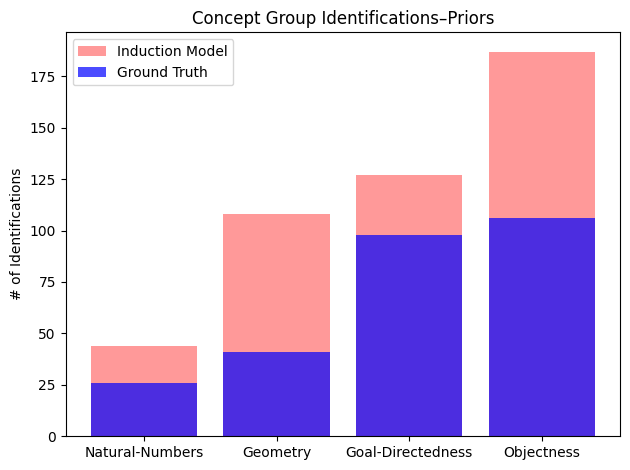

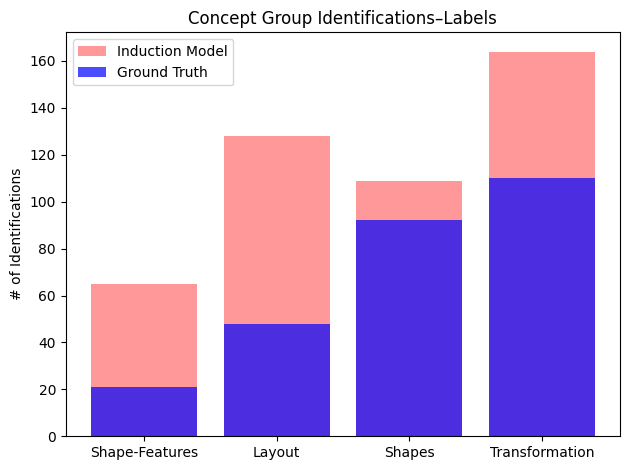

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

concept_group_df_CoreTheory = (identification.groupby('CoreTheory')[['Ground Truth', 'Induction']].sum().reset_index().rename(columns={'CoreTheory': 'concept group'}))
concept_group_df_CLIPARC = (identification.groupby('CLIPARC')[['Ground Truth', 'Induction']].sum().reset_index().rename(columns={'CLIPARC': 'concept group'}))

print(concept_group_df_CoreTheory)
print()
print(concept_group_df_CLIPARC)

def plot_concept_group_stats(concept_group_df, group_name):
    concept_group_df = concept_group_df.sort_values(by=['Ground Truth'], ascending=[True])
    plt.bar(concept_group_df['concept group'], concept_group_df['Induction'], color='red', alpha=0.4, label='Induction Model')
    plt.bar(concept_group_df['concept group'], concept_group_df['Ground Truth'], color='blue', alpha=0.7, label='Ground Truth')
    plt.ylabel('# of Identifications')
    plt.title(f'Concept Group Identifications–{group_name}')
    plt.xticks(rotation=0, ha='center')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_concept_group_stats(concept_group_df_CoreTheory, 'Priors')
print()
plot_concept_group_stats(concept_group_df_CLIPARC, 'Labels')

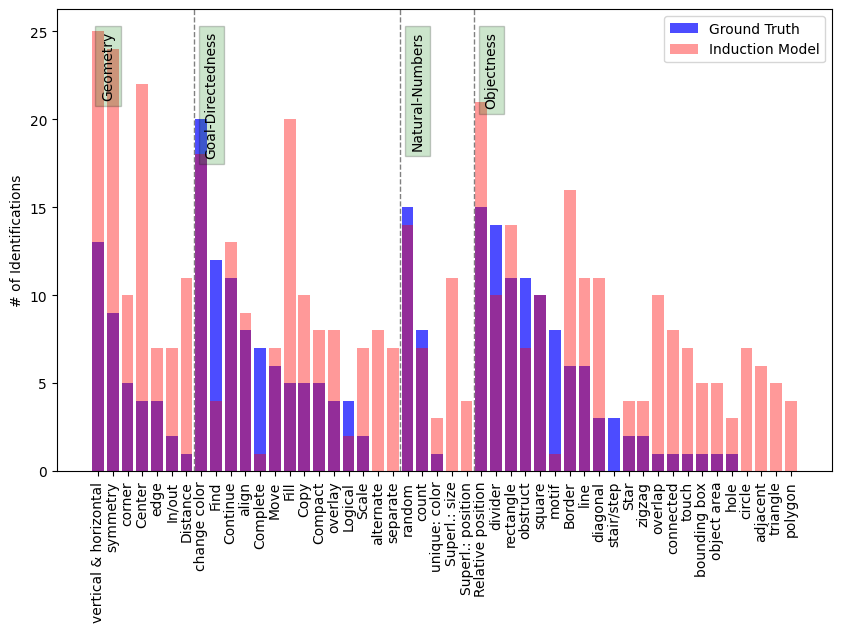

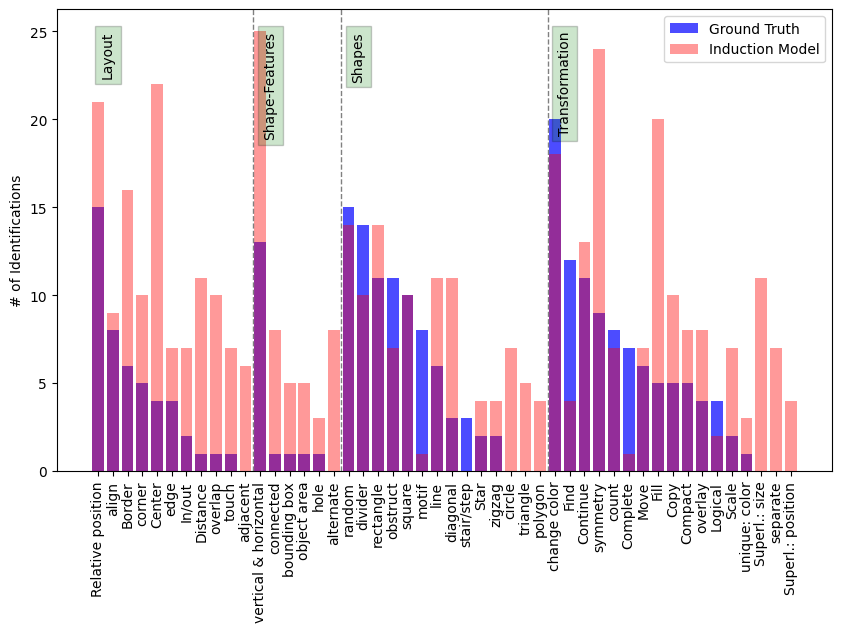

In [38]:
import matplotlib.pyplot as plt

# exclude those with < 2 occurance
filtered_identification = identification[(identification['Ground Truth'] >= 3) | (identification['Induction'] >= 3)]
filtered_identification = filtered_identification.sort_values(by=['Ground Truth', 'Induction'], ascending=[False, False])

def plot_per_group(filtered_identification, group_order):
    sorted_identification = filtered_identification.sort_values(by=[group_order, 'Ground Truth', 'Induction'], ascending=[True, False, False])

    plt.figure(figsize=(10, 6))
    plt.bar(sorted_identification['Short-concept-name'], sorted_identification['Ground Truth'], label='Ground Truth', color='blue', alpha=0.7)
    plt.bar(sorted_identification['Short-concept-name'], sorted_identification['Induction'], label='Induction Model', color='red', alpha=0.4)
    current_group = None
    group_start = 0
    for i, (concept, row) in enumerate(sorted_identification.iterrows()):
        if row[group_order] != current_group:
            if current_group is not None:
                # Draw a vertical dashed line
                plt.axvline(x=i - 0.5, color='gray', linestyle='--', linewidth=1)
                plt.text(group_start + 0.2, max(sorted_identification['Ground Truth'].max(), sorted_identification['Induction'].max()),
                         current_group, ha='left', va='top', fontsize=10, color='black', rotation=90, bbox=dict(facecolor='green', alpha=0.2))
            current_group = row[group_order]
            group_start = i
    plt.text(group_start + 0.2, max(sorted_identification['Ground Truth'].max(), sorted_identification['Induction'].max()) ,
             current_group, ha='left', va='top', fontsize=10, color='black', rotation=90, bbox=dict(facecolor='green', alpha=0.2))
    plt.ylabel('# of Identifications')
    plt.xticks(sorted_identification['Short-concept-name'], rotation=90, ha='center')
    plt.legend()
    plt.show()


plot_per_group(filtered_identification, 'CoreTheory')
print()
plot_per_group(filtered_identification, 'CLIPARC')

In [39]:
import pandas as pd
import numpy as np

def get_concept_occurrence_per_task(theory, solver):
    concept_occurrence_per_task = pd.DataFrame(0, index=coreconceptscsv.index, columns=conceptgroups[theory].unique())
    for idx, row in coreconceptscsv.iterrows():
        groups_in_task = conceptgroups[conceptgroups['Concept'].isin(row[solver])][theory]
        counts = groups_in_task.value_counts()
        for group, count in counts.items():
            concept_occurrence_per_task.at[idx, group] = count
    return concept_occurrence_per_task

summary_table = pd.DataFrame(columns=['Ground Truth', 'Human Inaccurate', 'Induction Accurate', 'Induction Inaccurate'],
                             index=np.concatenate((conceptgroups['CoreTheory'].unique(), conceptgroups['CLIPARC'].unique()), axis=0))

for theory in ['CoreTheory', 'CLIPARC']:
    for model in ['Ground Truth', 'Human Inaccurate', 'Induction Accurate', 'Induction Inaccurate']:
        df = get_concept_occurrence_per_task(theory, model)
        averages = round(df.replace(0, np.nan).mean(), 2)
        averages.columns = ["Concept Group", f"{theory}_{model}"]
        for idx, row in averages.items():
            summary_table.at[idx, model] = row
col_sums = summary_table.sum()
print(col_sums)
summary_table

Ground Truth            14.01
Human Inaccurate        13.19
Induction Accurate      14.58
Induction Inaccurate    20.26
dtype: object


,Ground Truth,Human Inaccurate,Induction Accurate,Induction Inaccurate
Objectness,2.36,2.33,2.12,4.08
Goal-Directedness,2.09,1.7,1.88,2.43
Geometry,1.37,1.29,1.87,2.07
Natural-Numbers,1.18,1.11,1.22,1.4
Shapes,2.0,2.29,1.58,2.79
Layout,1.66,1.67,2.62,2.62
Shape-Features,1.11,1.0,1.0,1.75
Transformation,2.24,1.8,2.29,3.12


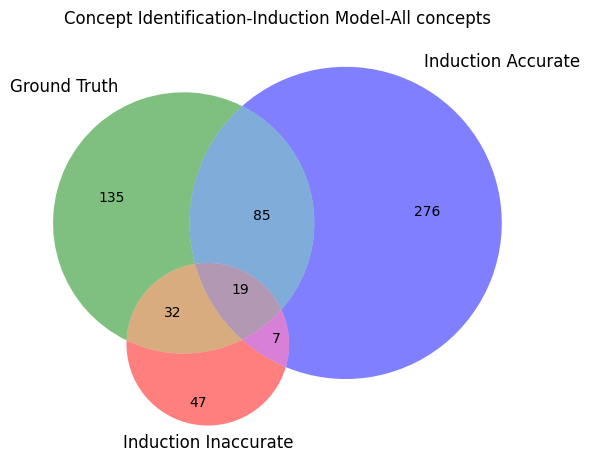

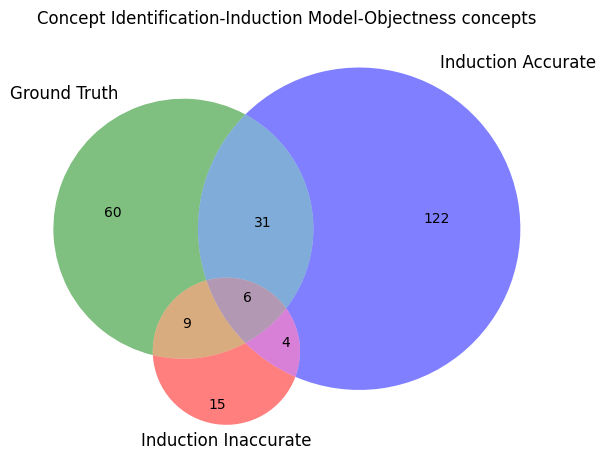

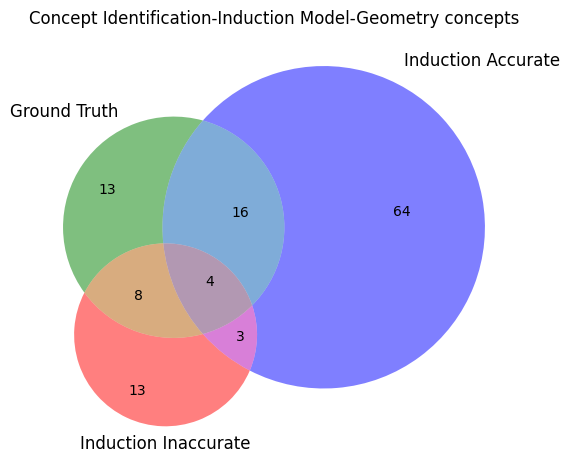

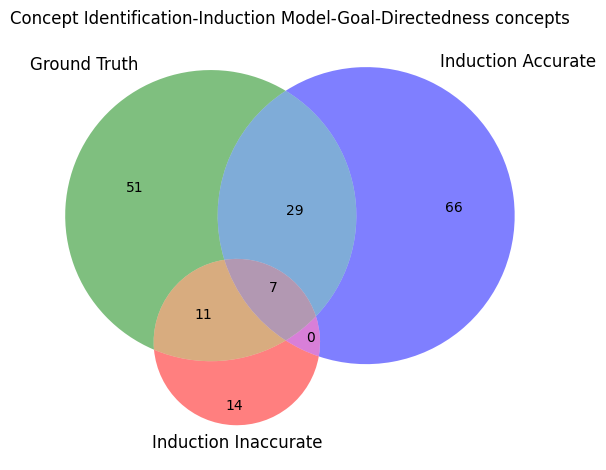

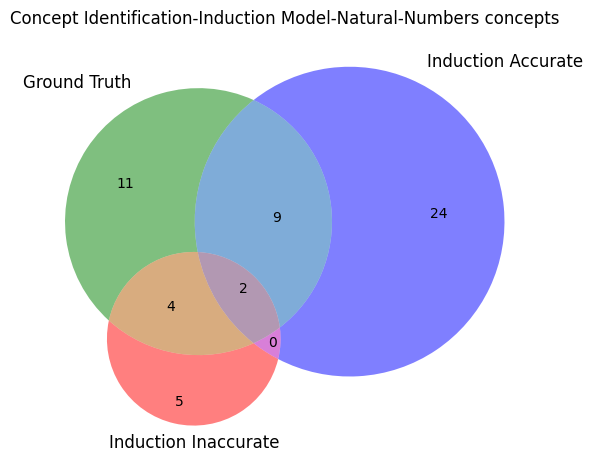

In [86]:
import pandas as pd
from matplotlib_venn import venn3, venn2
import matplotlib.pyplot as plt

def getmodelvenn(df, name):
    sums = df.sum()
    venn3(subsets=(sums['TFF'], sums['FTF'], sums['TTF'], sums['FFT'], sums['TFT'], sums['FTT'], sums['TTT']), set_labels=('Ground Truth', 'Induction Accurate', 'Induction Inaccurate'),
          set_colors=("green", "blue", "red"), alpha=0.5)
    plt.title(f'Concept Identification-Induction Model-{name} concepts')
    plt.tight_layout()
    plt.show()

def gethumanvenn(df):
    sums = df.sum()
    venn2((sums['NY'], sums['YN'], sums['YY']), set_labels=('Human Inaccurate', 'Human Accurate\n  (Ground Truth)'))
    plt.title('Concept Categories–Human')
    plt.tight_layout()
    plt.show()

getmodelvenn(identification, 'All')
getmodelvenn(identification[identification['CoreTheory'] == 'Objectness'], 'Objectness')
getmodelvenn(identification[identification['CoreTheory'] == 'Geometry'], 'Geometry')
getmodelvenn(identification[identification['CoreTheory'] == 'Goal-Directedness'], 'Goal-Directedness')
getmodelvenn(identification[identification['CoreTheory'] == 'Natural-Numbers'], 'Natural-Numbers')

In [98]:
import pandas as pd
categories = ['Shapes', 'Layout', 'Shape-Features', 'Transformation']
categories = ['Objectness', 'Geometry', 'Goal-Directedness', 'Natural-Numbers']
patterns = ['TTT', 'TFT', 'TTF', 'TFF', 'FTT', 'FFT', 'FTF']
patterns = ['YY', 'NY', 'YN']

rows = []
for cat in categories:
    df_subset = identification[identification['CoreTheory'] == cat]
    sums = df_subset[patterns].sum()
    row = [cat] + [sums[p] for p in patterns]
    rows.append(row)

col_names = ["CoreTheory"] + patterns
results_df = pd.DataFrame(rows, columns=col_names)

print(results_df)
latex_table = results_df.to_latex(
    index=False,
    columns=col_names,
    header=col_names,
    caption="Occurrences of Concepts by CoreTheory and Patterns",
    label="tab:concept_patterns")

print(latex_table)


          CoreTheory  YY  NY  YN
0         Objectness  34   1  72
1           Geometry   9   0  32
2  Goal-Directedness  24  10  74
3    Natural-Numbers   9   1  17
\begin{table}
\caption{Occurrences of Concepts by CoreTheory and Patterns}
\label{tab:concept_patterns}
\begin{tabular}{lrrr}
\toprule
CoreTheory & YY & NY & YN \\
\midrule
Objectness & 34 & 1 & 72 \\
Geometry & 9 & 0 & 32 \\
Goal-Directedness & 24 & 10 & 74 \\
Natural-Numbers & 9 & 1 & 17 \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
import pandas as pd
import numpy as np

matrix = np.zeros((4, 4), dtype=int)
coretheory_groups, cliparc_groups = conceptgroups['CoreTheory'].unique(), conceptgroups['CLIPARC'].unique()
coretheory_group_to_index = {group: idx for idx, group in enumerate(coretheory_groups)}
cliparc_group_to_index = {group: idx for idx, group in enumerate(cliparc_groups)}

for _, row in conceptgroups.iterrows():
    matrix[coretheory_group_to_index[row['CoreTheory']], cliparc_group_to_index[row['CLIPARC']]] += 1

import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl

fig, ax = plt.subplots()
im = ax.imshow(matrix)

ax.set_yticks(np.arange(4), labels=coretheory_groups)
ax.set_xticks(np.arange(4), labels=cliparc_groups)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor", fontsize=8)
plt.setp(ax.get_yticklabels(), rotation=45, ha="right", fontsize=8)
plt.ylabel('Core Knowledge Priors')
plt.xlabel('Core Knowlege Labels')

for i in range(4):
    for j in range(4):
        text = ax.text(j, i, matrix[i, j], ha="center", va="center", color="black")

fig.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl

def get_coocurrance(theory, solver = 'Ground Truth'):
    all_concepts = conceptgroups['Concept'].unique()
    co_occurrence = pd.DataFrame(0, index=all_concepts, columns=all_concepts, dtype=int)
    for _, row in coreconceptscsv.iterrows():
        task_concepts = set(row[solver])
        for concept_i in task_concepts:
            for concept_j in task_concepts:
                co_occurrence.loc[concept_i, concept_j] += 1

    concept_to_group = conceptgroups.set_index('Concept')[theory]
    sorted_concepts = concept_to_group.sort_values().index
    return co_occurrence.loc[sorted_concepts, sorted_concepts] > 1

def plot_matrix(co_occurrence, theory, title = 'Matrix'):
    group_boundaries = conceptgroups.groupby(theory)['Concept'].apply(list)
    group_sizes = group_boundaries.apply(len)
    group_positions = group_sizes.cumsum()

    plt.figure()
    for i in range(len(group_positions)):
        pos = group_positions[i]
        plt.axhline(y=pos - 0.5, color='black', linewidth=2)
        plt.axvline(x=pos - 0.5, color='black', linewidth=2)
        plt.text(-2, pos - group_sizes[i]/2 , group_sizes.index[i],
                 ha='right', va='center', fontsize=8, color='black', rotation=45)
        plt.text(pos - group_sizes[i]/2, 74 , group_sizes.index[i],
                 ha='right', va='top', fontsize=8, color='black', rotation=45)

    plt.title(title)
    plt.tight_layout()
    img = plt.imshow(co_occurrence, cmap=(mpl.colors.ListedColormap(['white', 'green', 'royalblue', 'red', 'cyan', 'orange', 'pink', 'purple'])))
    cbar = plt.colorbar(img)
    cbar.set_ticks([0.5, 1.3, 2.2, 3.0, 3.9, 4.8, 5.7, 6.6], labels=['None','GT', 'IA','II', 'GT∪IA','GT∪II','IC∪II', 'GT∪IA∪II'], rotation=90, va='center')
    cbar.set_label('Identified by')
    plt.xticks([])
    plt.yticks([])
    plt.show()

human_coocurance = get_coocurrance('CoreTheory', 'Ground Truth')
incorrect_coocurance = get_coocurrance('CoreTheory', 'Induction Inaccurate')
correct_coocurance = get_coocurrance('CoreTheory', 'Induction Accurate')

plot_matrix(human_coocurance+correct_coocurance*2+incorrect_coocurance*4, 'CoreTheory', '2+ Concept Co-ocurrence-CoreTheory')
plot_matrix(human_coocurance+correct_coocurance*2+incorrect_coocurance*4, 'CLIPARC', '2+ Concept Co-ocurrence-CLIPARC')

# Accuracy

<ipython-input-101-b018b1e29b3b>:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  performance_summary = coreconceptscsv.groupby('Human Bracket').apply(
<ipython-input-101-b018b1e29b3b>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  performance_summary = coreconceptscsv.groupby('Human Bracket').apply(


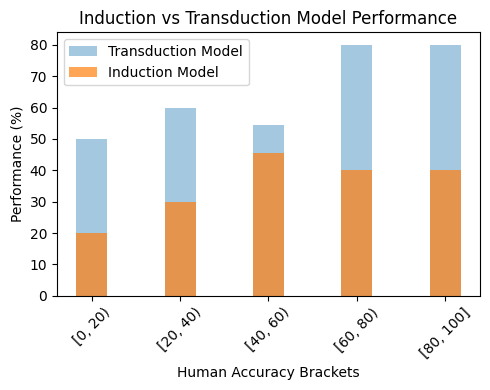

<ipython-input-101-b018b1e29b3b>:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  performance_summary = coreconceptscsv.groupby('Human Bracket').apply(
<ipython-input-101-b018b1e29b3b>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  performance_summary = coreconceptscsv.groupby('Human Bracket').apply(


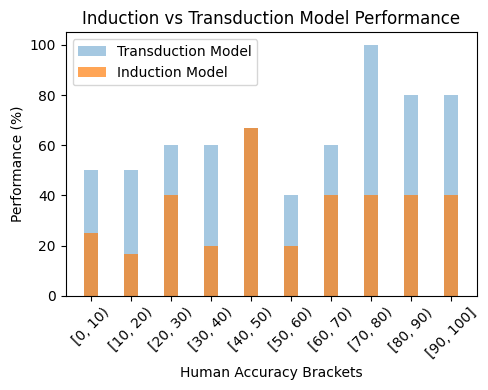

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def is_transduction_accurate(row):
    return any(row[col] == 1 for col in ['Potpourri', 'Potpourri TTF', 'Potpourri Reranking',
                                        'Potpourri TTF Reranking ', 'Heavy', 'Heavy TTF'])
coreconceptscsv['Transduction Performance'] = coreconceptscsv.apply(is_transduction_accurate, axis=1)
coreconceptscsv['Induction Performance'] = coreconceptscsv['Induction Accurate'].apply(lambda x: x != [])

def get_bracket_performance(bins = [0, 20, 40, 60, 80, 100], labels = ['[0, 20)', '[20, 40)', '[40, 60)', '[60, 80)', '[80, 100]']):
    coreconceptscsv['Human Bracket'] = pd.cut(coreconceptscsv['Human Performance'], bins=bins, labels=labels, right=False)
    performance_summary = coreconceptscsv.groupby('Human Bracket').apply(
        lambda x: pd.Series({'Induction Performance': x['Induction Performance'].sum() / len(x) * 100,
            'Transduction Performance': x['Transduction Performance'].sum() / len(x) * 100})).reset_index()
    x = np.arange(len(performance_summary['Human Bracket']))
    plt.figure(figsize=(5, 4))
    plt.bar(x , performance_summary['Transduction Performance'], 0.35, label='Transduction Model', alpha=0.4)
    plt.bar(x , performance_summary['Induction Performance'], 0.35, label='Induction Model', alpha=0.7)

    plt.xlabel('Human Accuracy Brackets')
    plt.ylabel('Performance (%)')
    plt.title('Induction vs Transduction Model Performance')
    plt.xticks(x, performance_summary['Human Bracket'], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

get_bracket_performance()
get_bracket_performance([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
         ['[0, 10)', '[10, 20)', '[20, 30)', '[30, 40)','[40, 50)', '[50, 60)', '[60, 70)', '[70, 80)', '[80, 90)', '[90, 100]'])

In [ ]:
import pandas as pd

def get_concepts(col):
    all_GT_concepts = set(coreconceptscsv['Ground Truth'].explode())
    success_cases = coreconceptscsv[(coreconceptscsv[col] == True)]
    listconc = success_cases['Ground Truth'][success_cases[col] == True].dropna(how='all')
    GT_concepts = set(listconc.explode())
    return GT_concepts, all_GT_concepts-GT_concepts

GT_concepts_in_transduction, missing_GT_concepts_from_transduction = get_concepts('Transduction Performance')
GT_concepts_in_induction, missing_GT_concepts_from_induction = get_concepts('Induction Performance')
print(len(GT_concepts_in_transduction), 'concepts used in transduction and',len(missing_GT_concepts_from_transduction) , 'missing.')
print('Missing concepts in transduction:', missing_GT_concepts_from_transduction)
print()
print(len(GT_concepts_in_induction), 'concepts used in induction and',len(missing_GT_concepts_from_induction) , 'missing.')
print('Missing concepts in induction:', missing_GT_concepts_from_induction)
print()

47 concepts used in transduction and 7 missing.
Missing concepts in transduction: {'overlap', 'bounding box', 'sort', 'connect', 'star/flower/plus/T-shape', 'gap/distance', 'touch'}

34 concepts used in induction and 20 missing.
Missing concepts in induction: {'overlap', 'connect', 'star/flower/plus/T-shape', 'between', 'invert', 'path', 'diagonal', 'stair/step', 'connected', 'sort', 'scale size', 'superlative: repetition', 'wave', 'parallel', 'middle/center', 'unique: color', 'bounding box', 'zigzag', 'L-shape', 'touch'}



In [106]:
import pandas as pd

brackets = [(0, 20), (20, 40), (40, 60), (60, 80), (80, 101)]
coreconceptscsv = coreconceptscsv.sort_values(by='Human Performance')

bracket_concept_sets = []
used_concepts_so_far = set()

for bracket_min, bracket_max in brackets:
    bracket_df = coreconceptscsv[
        (coreconceptscsv['Human Performance'] >= bracket_min) &
        (coreconceptscsv['Human Performance'] < bracket_max)]

    all_gt_in_bracket = set()
    for _, row in bracket_df.iterrows():
        all_gt_in_bracket.update(row['Ground Truth'])
    new_concepts = all_gt_in_bracket - used_concepts_so_far

    used_concepts_so_far.update(new_concepts)

    bracket_concept_sets.append({
        'bracket': f'{bracket_min}-{bracket_max}',
        'tasks': bracket_df['Task.json'].tolist(),
        'gt_concepts': new_concepts
    })

analysis_results = []
for bracket_data in bracket_concept_sets:
    bracket_label = bracket_data['bracket']
    bracket_tasks = bracket_data['tasks']
    bracket_concepts = bracket_data['gt_concepts']  # Unique to this bracket

    # Subset the DF to just this bracket’s tasks
    bracket_df = coreconceptscsv[coreconceptscsv['Task.json'].isin(bracket_tasks)]

    solved_tasks_induction = bracket_df[bracket_df['Induction Performance'] == 1]
    induction_solved_concepts = set()
    for _, row in solved_tasks_induction.iterrows():
        induction_solved_concepts.update(row['Ground Truth'])

    induction_solved_concepts = induction_solved_concepts & bracket_concepts
    induction_unsolved_concepts = bracket_concepts - induction_solved_concepts
    solved_tasks_transduction = bracket_df[bracket_df['Transduction Performance'] == 1]
    transduction_solved_concepts = set()
    for _, row in solved_tasks_transduction.iterrows():
        transduction_solved_concepts.update(row['Ground Truth'])

    transduction_solved_concepts = transduction_solved_concepts & bracket_concepts
    transduction_unsolved_concepts = bracket_concepts - transduction_solved_concepts

    analysis_results.append({
        'bracket': bracket_label,
        'bracket_concepts': bracket_concepts,
        'induction_solved_concepts': induction_solved_concepts,
        'induction_unsolved_concepts': induction_unsolved_concepts,
        'transduction_solved_concepts': transduction_solved_concepts,
        'transduction_unsolved_concepts': transduction_unsolved_concepts})

# 5) Example printing or further analysis
for item in analysis_results:
    print("Bracket:", item['bracket'])
    print("  # of bracket concepts:", len(item['bracket_concepts']), item['bracket_concepts'])
    print("  Induction solved concepts:", len(item['induction_solved_concepts']), item['induction_solved_concepts'])
    print("  Induction unsolved concepts:", len(item['induction_unsolved_concepts']), item['induction_unsolved_concepts'])
    print("  Transduction solved concepts:", len(item['transduction_solved_concepts']), item['transduction_solved_concepts'])
    print("  Transduction unsolved concepts:", len(item['transduction_unsolved_concepts']), item['transduction_unsolved_concepts'])
    print("  ---")


Bracket: 0-20
  # of bracket concepts: 32 {'edge', 'connected', 'find pattern/shape/object', 'line', 'left/right/top/bottom/above/below', 'logical operation', 'extend/continue/propagate', 'square', 'connect', 'surround/border/boundary', 'change color', 'obstruct', 'divider', 'diagonal', 'middle/center', 'repeat/copy', 'touch', 'symmetry', 'motif', 'zigzag', 'overlay', 'parallel', 'fill with color/pattern', 'rectangle', 'corner', 'scale size', 'random', 'wave', 'align', 'invert', 'overlap', 'complete'}
  Induction solved concepts: 7 {'repeat/copy', 'symmetry', 'change color', 'left/right/top/bottom/above/below', 'overlay', 'logical operation', 'divider'}
  Induction unsolved concepts: 25 {'edge', 'connected', 'find pattern/shape/object', 'line', 'extend/continue/propagate', 'square', 'connect', 'surround/border/boundary', 'obstruct', 'diagonal', 'middle/center', 'touch', 'motif', 'zigzag', 'parallel', 'fill with color/pattern', 'rectangle', 'corner', 'scale size', 'random', 'wave', 'ali

# Archive: Human Error Extraction

In [ ]:
harc_errors = pd.read_csv('/content/CLIPARC/clean_errors.csv')
harc_errors[harc_errors['task_type'] == 'evaluation']
harc_in_study = harc_errors[harc_errors['task_name'].isin(coreconceptscsv['Task.json'] + '.json')]
harc_in_study = harc_in_study.drop(columns=['task_type', 'hashed_output_grid'], errors='ignore')
print('Unique Tasks:', len(harc_in_study['task_name'].unique()))
print('Unique Errors:', len(harc_in_study))
harc_in_study = harc_in_study[harc_in_study['count'] > 1]
print('Unique Errors with 2+ occurance:', len(harc_in_study))
print('Unique Tasks with an error of 2+ occurance', len(harc_in_study['task_name'].unique()))
print()
summary = (harc_in_study.groupby('task_name', as_index=False).agg(total_errors=('count', 'sum'), total_unique_errors=('task_name', 'size')))
summary['2+ same error'] = summary['total_errors'] - summary['total_unique_errors']
summary = summary[summary['2+ same error'] > 0]
summary = summary.sort_values(by='2+ same error', ascending=False)
#print(summary)


summary_2 = (harc_in_study.groupby('task_name', as_index=False).agg(test_output_grid_list=('test_output_grid', lambda x: list(x))))
summary_2['error_count'] = [len(summary_2.iloc[i]['test_output_grid_list']) for i in range(len(summary_2))]
print(summary_2)

Unique Tasks: 51
Unique Errors: 594
Unique Errors with 2+ occurance: 34
Unique Tasks with an error of 2+ occurance 21

        task_name                              test_output_grid_list  \
0   0934a4d8.json                            [|6966|9399|3499|1941|]   
1   1c56ad9f.json  [|000000000000000|000077777770000|000700700700...   
2   1d0a4b61.json  [|1111111111111111111111111|128155182128155182...   
3   1e81d6f9.json  [|000500000000000|010500001000000|000503000080...   
4   22a4bbc2.json                                    [|000|000|000|]   
5   2685904e.json  [|8800000000|0000000000|0000000000|0000000000|...   
6   3d31c5b3.json   [|080000|404088|202080|, |505425|250225|555422|]   
7   5207a7b5.json  [|888566000|888560000|888560000|888500000|8885...   
8   642248e4.json  [|200000000000000108|201000000010000008|200000...   
9   69889d6e.json  [|0000000001|0000000011|0000000110|0000001100|...   
10  712bf12e.json  [|0205050000055|0200050505552|0200005000022|52...   
11  73182012.json

In [ ]:
!git clone https://github.com/fchollet/ARC-AGI.git
import json
import os
import matplotlib.pyplot as plt
import numpy as np

evaluation_challenges_path = '/content/ARC-AGI/data/evaluation/'

evaluation_challenges = []
for filename in os.listdir(evaluation_challenges_path):
    if filename.endswith('.json'):
        file_path = os.path.join(evaluation_challenges_path, filename)
        with open(file_path) as fp:
            evaluation_challenges.append(json.load(fp))

fatal: destination path 'ARC-AGI' already exists and is not an empty directory.


0 0934a4d8 1
Training examples: 4


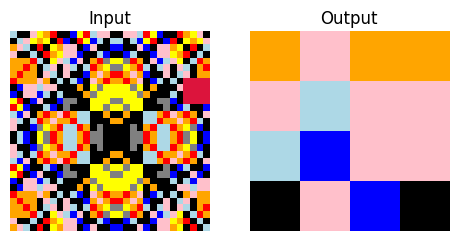

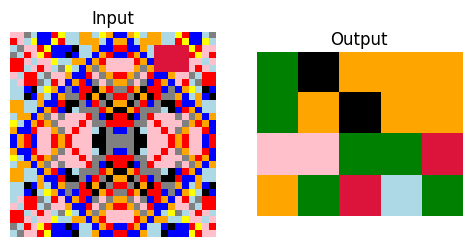

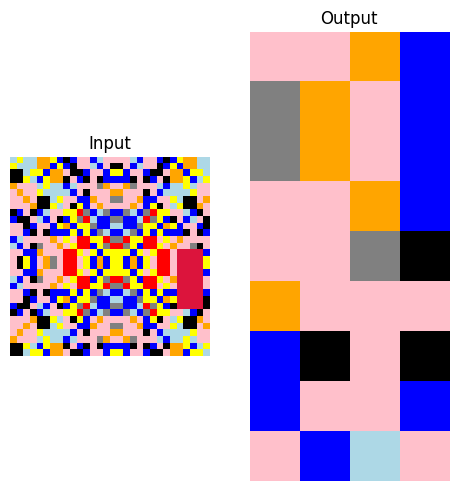

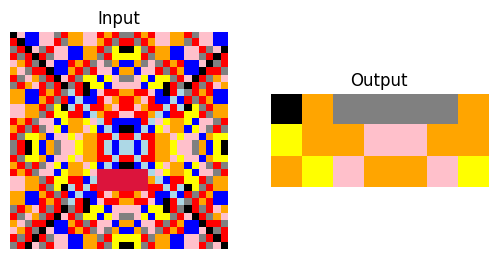

Test Input: 1


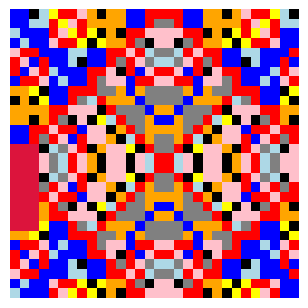

Human Error 1 of 1


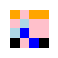


1 1c56ad9f 1
Training examples: 4


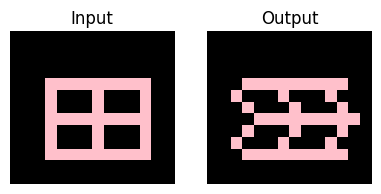

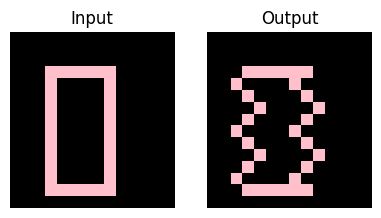

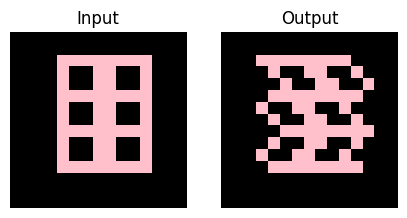

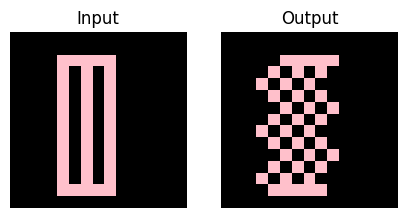

Test Input: 1


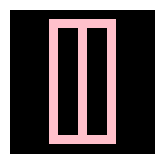

Human Error 1 of 1


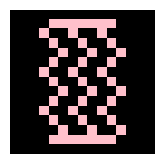


2 1d0a4b61 1
Training examples: 3


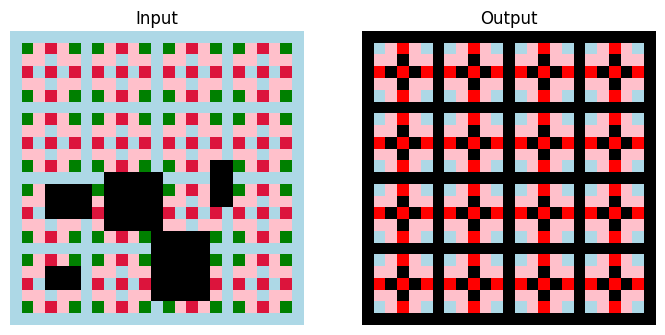

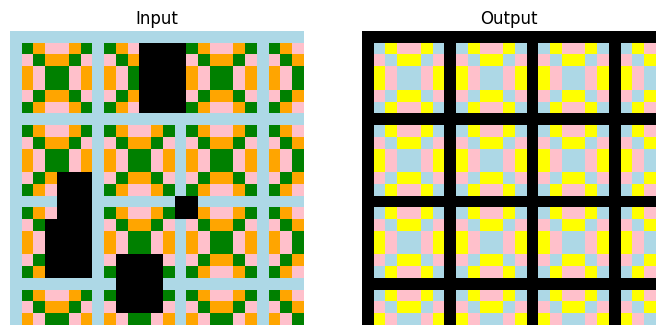

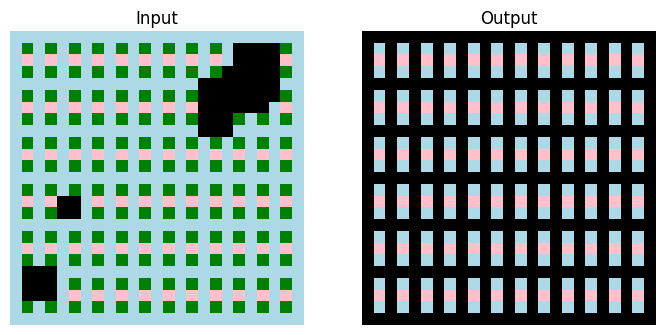

Test Input: 1


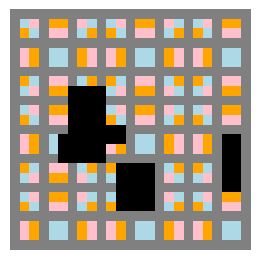

Human Error 1 of 1


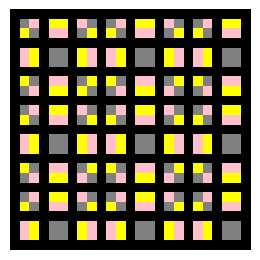


3 1e81d6f9 2
Training examples: 3


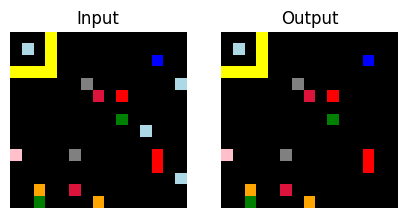

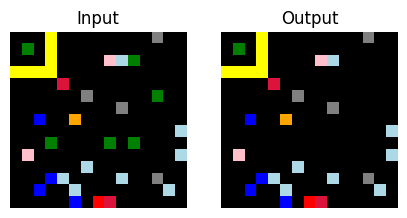

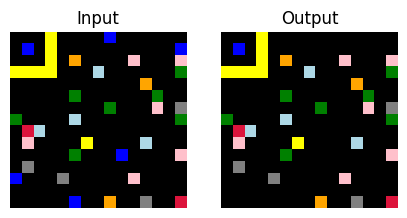

Test Input: 1


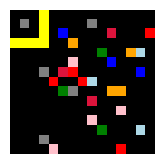

Human Error 1 of 2


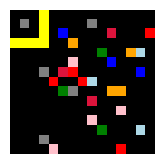

Training examples: 3


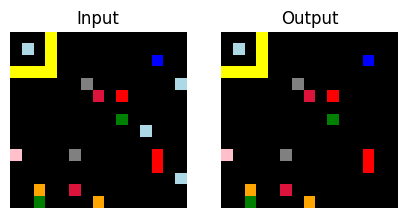

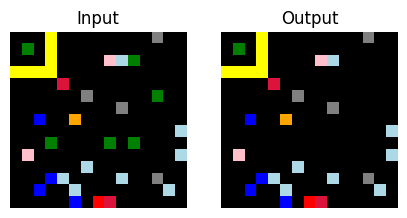

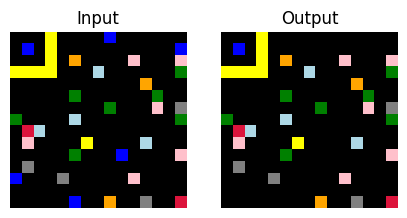

Test Input: 1


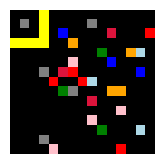

Human Error 2 of 2


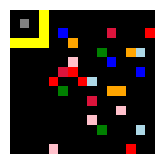


4 22a4bbc2 1
Training examples: 4


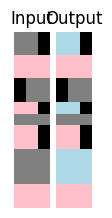

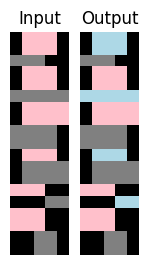

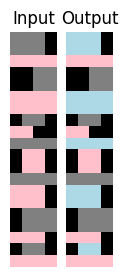

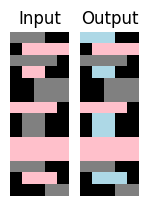

Test Input: 1


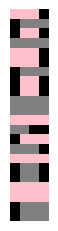

Human Error 1 of 1


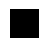


5 2685904e 2
Training examples: 6


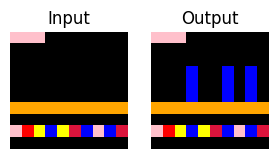

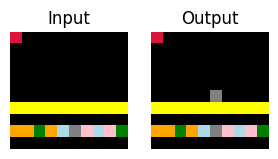

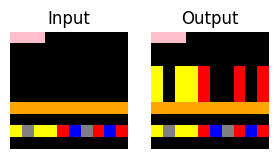

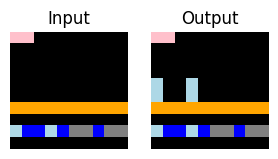

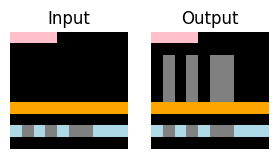

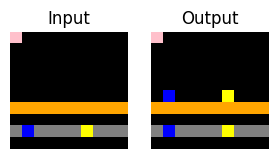

Test Input: 1


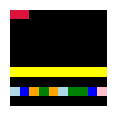

Human Error 1 of 2


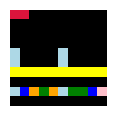

Training examples: 6


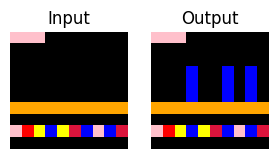

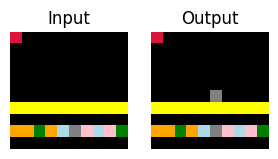

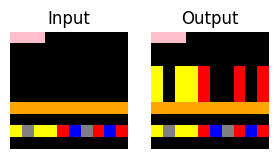

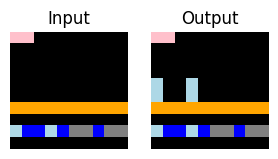

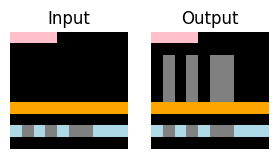

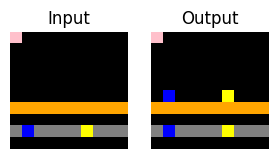

Test Input: 1


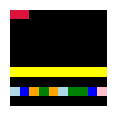

Human Error 2 of 2


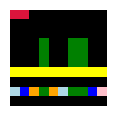


6 3d31c5b3 2
Training examples: 6


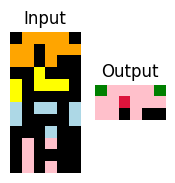

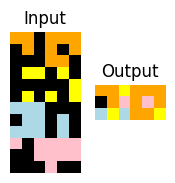

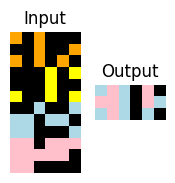

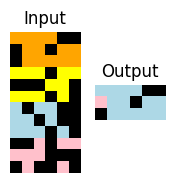

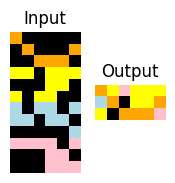

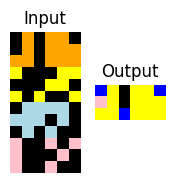

Test Input: 1


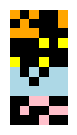

Human Error 1 of 2


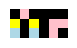

Training examples: 6


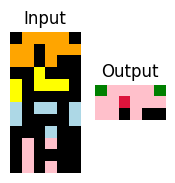

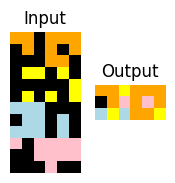

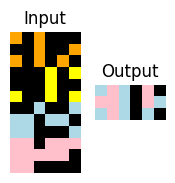

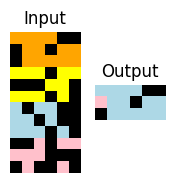

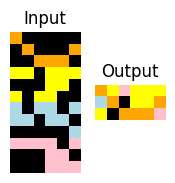

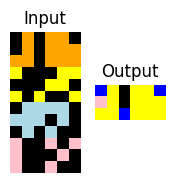

Test Input: 1


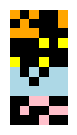

Human Error 2 of 2


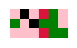


7 5207a7b5 1
Training examples: 3


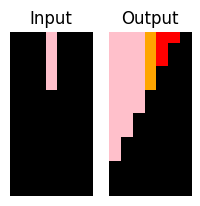

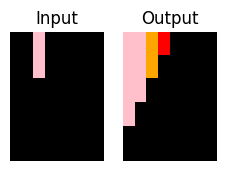

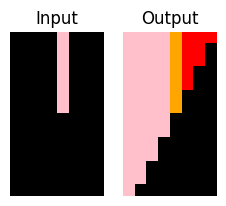

Test Input: 1


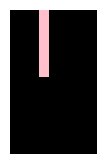

Human Error 1 of 1


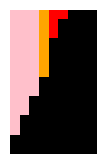


8 642248e4 1
Training examples: 3


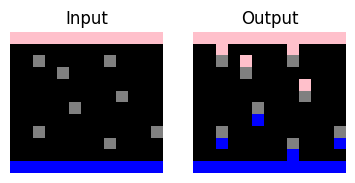

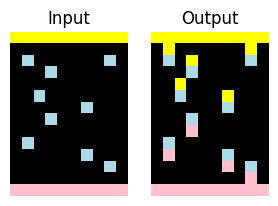

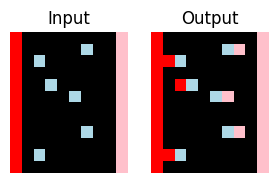

Test Input: 1


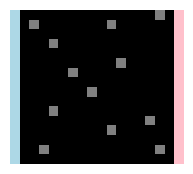

Human Error 1 of 1


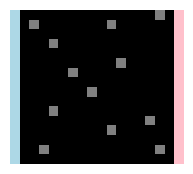


9 69889d6e 2
Training examples: 4


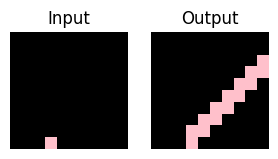

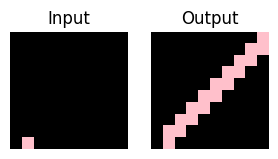

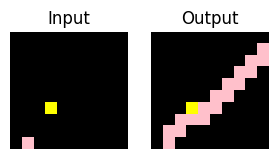

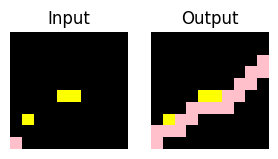

Test Input: 1


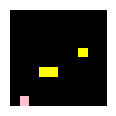

Human Error 1 of 2


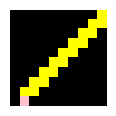

Training examples: 4


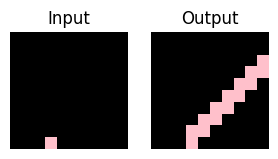

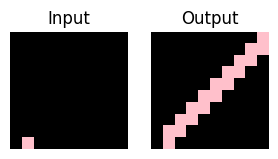

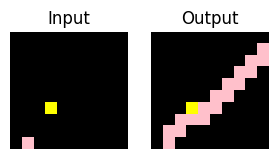

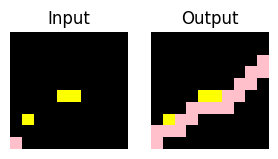

Test Input: 1


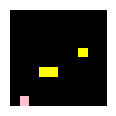

Human Error 2 of 2


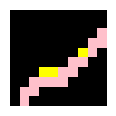


10 712bf12e 2
Training examples: 3


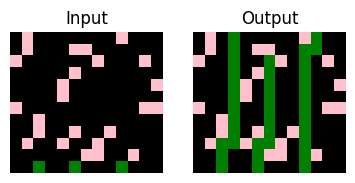

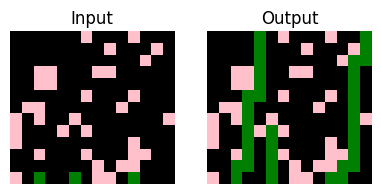

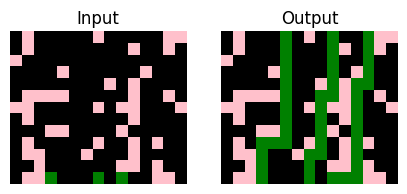

Test Input: 1


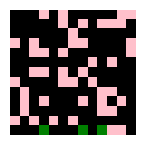

Human Error 1 of 2


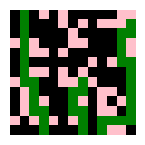

Training examples: 3


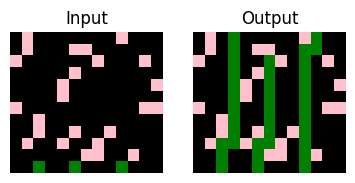

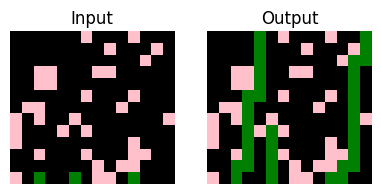

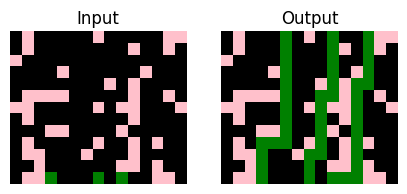

Test Input: 1


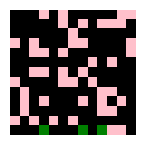

Human Error 2 of 2


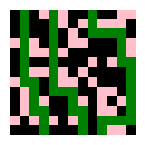


11 73182012 1
Training examples: 3


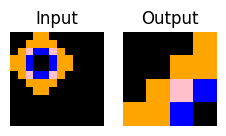

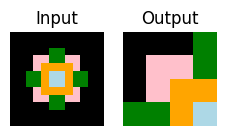

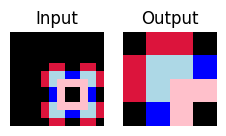

Test Input: 1


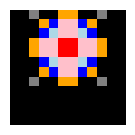

Human Error 1 of 1


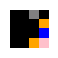


12 84db8fc4 1
Training examples: 4


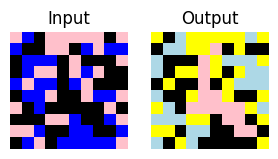

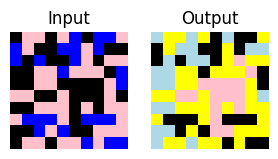

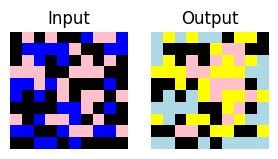

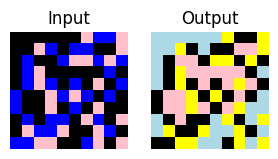

Test Input: 1


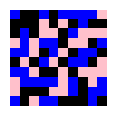

Human Error 1 of 1


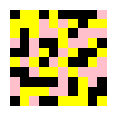


13 a59b95c0 2
Training examples: 5


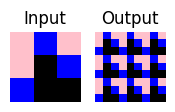

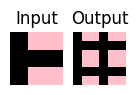

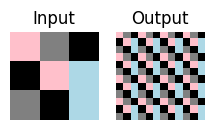

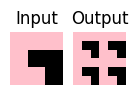

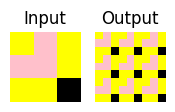

Test Input: 1


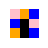

Human Error 1 of 2


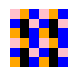

Training examples: 5


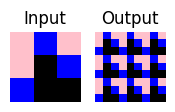

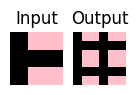

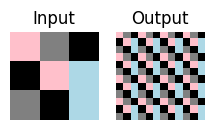

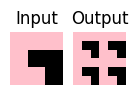

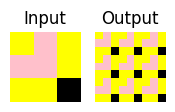

Test Input: 1


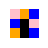

Human Error 2 of 2


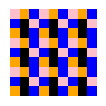


14 b4a43f3b 2
Training examples: 4


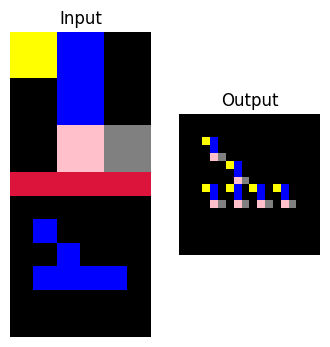

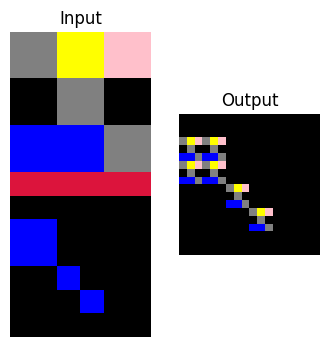

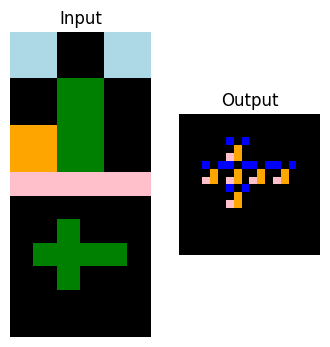

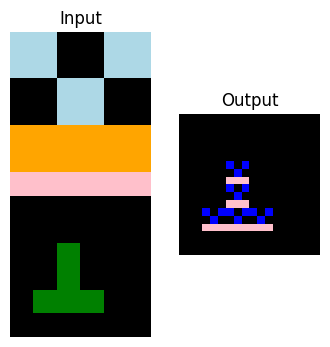

Test Input: 1


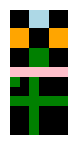

Human Error 1 of 2


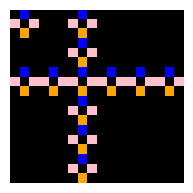

Training examples: 4


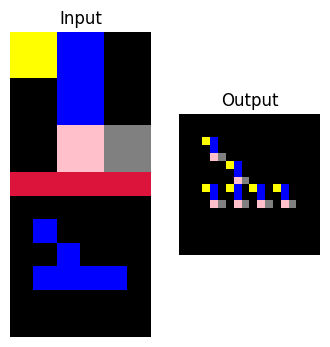

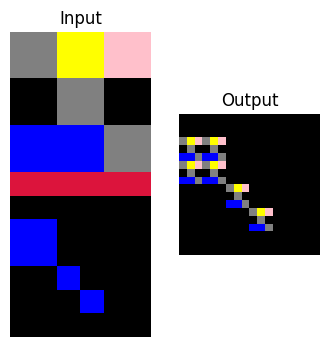

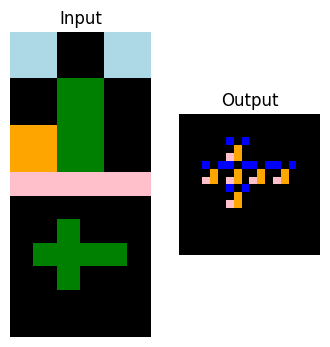

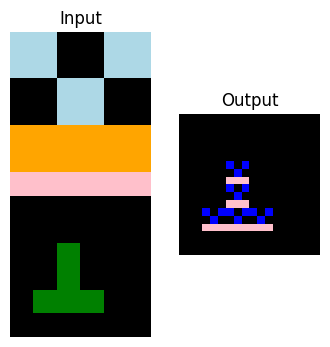

Test Input: 1


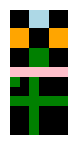

Human Error 2 of 2


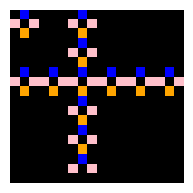


15 ccd554ac 2
Training examples: 6


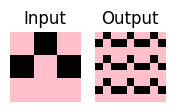

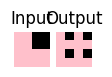

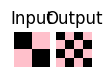

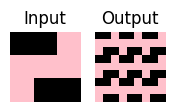

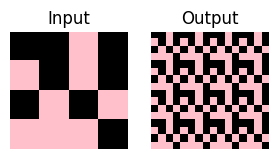

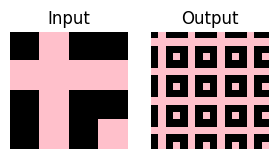

Test Input: 1


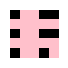

Human Error 1 of 2


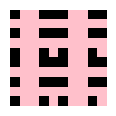

Training examples: 6


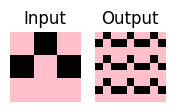

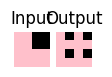

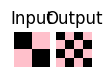

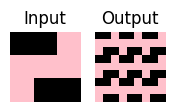

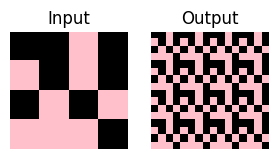

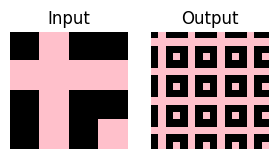

Test Input: 1


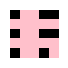

Human Error 2 of 2


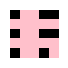


16 dc2aa30b 1
Training examples: 3


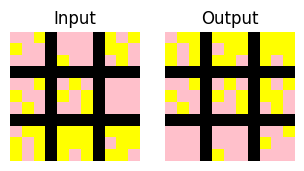

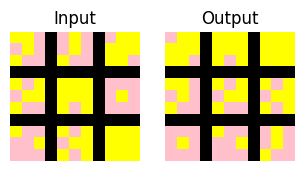

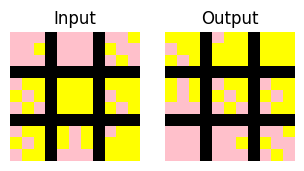

Test Input: 1


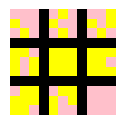

Human Error 1 of 1


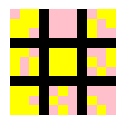


17 e6de6e8f 1
Training examples: 3


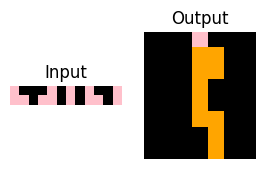

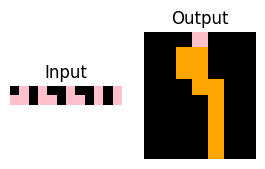

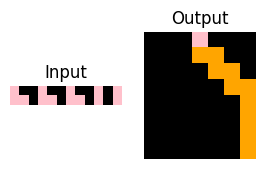

Test Input: 1


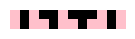

Human Error 1 of 1


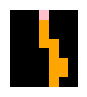


18 f3b10344 1
Training examples: 3


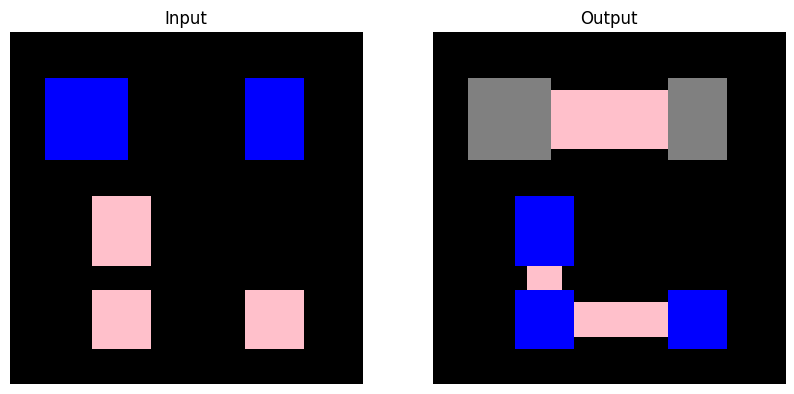

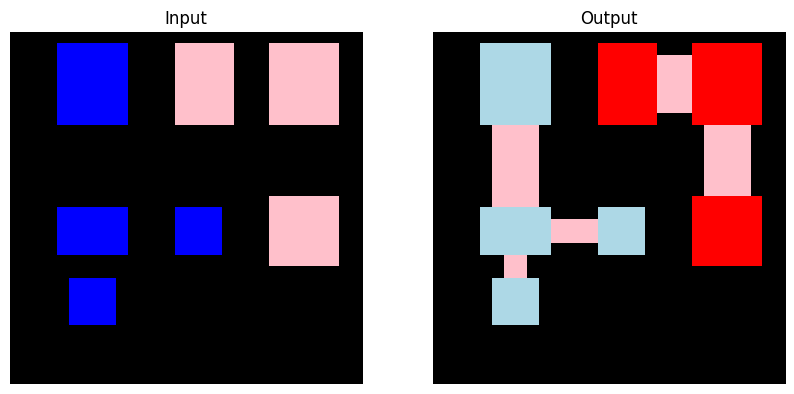

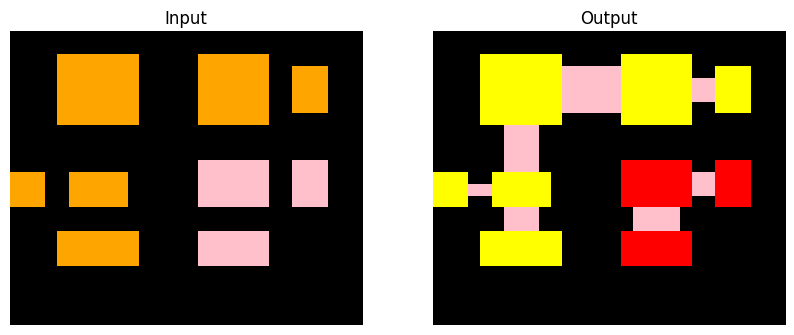

Test Input: 1


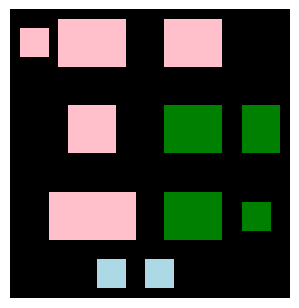

Human Error 1 of 1


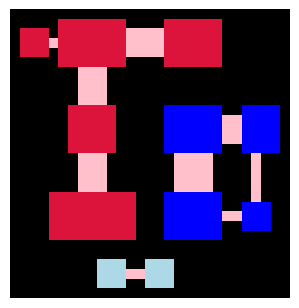


19 f45f5ca7 1
Training examples: 3


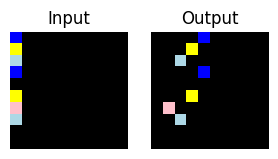

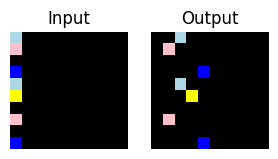

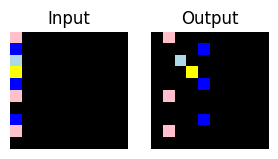

Test Input: 1


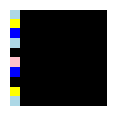

Human Error 1 of 1


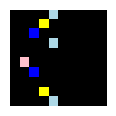


20 fea12743 6
Training examples: 3


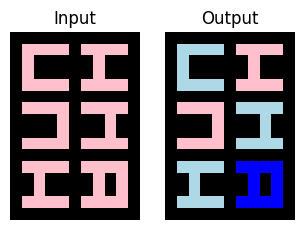

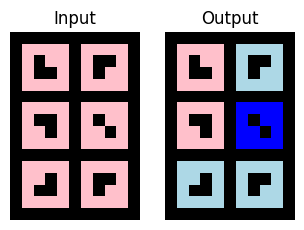

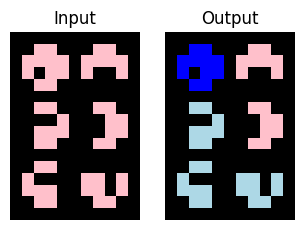

Test Input: 1


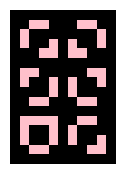

Human Error 1 of 6


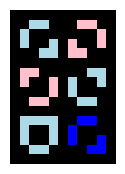

Training examples: 3


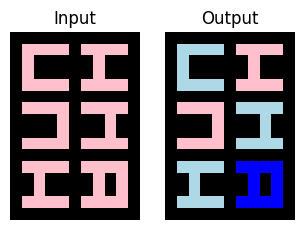

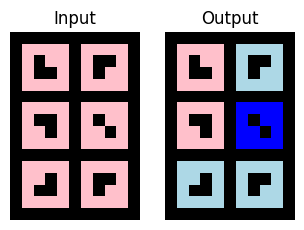

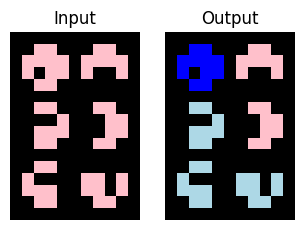

Test Input: 1


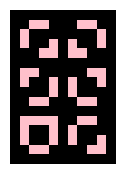

Human Error 2 of 6


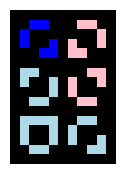

Training examples: 3


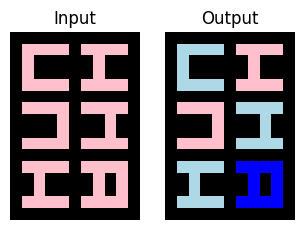

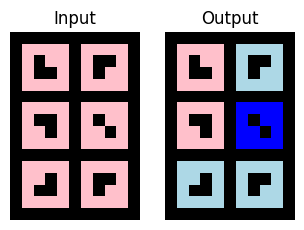

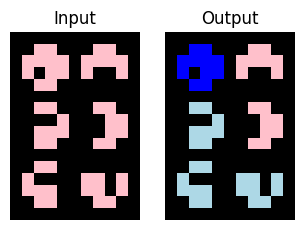

Test Input: 1


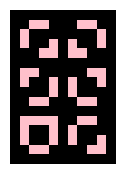

Human Error 3 of 6


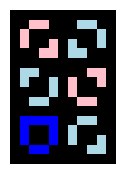

Training examples: 3


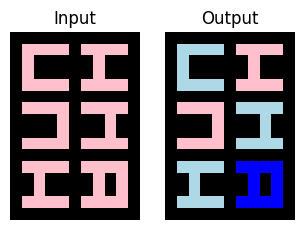

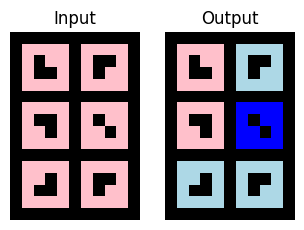

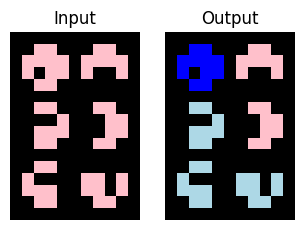

Test Input: 1


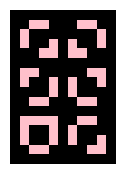

Human Error 4 of 6


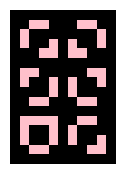

Training examples: 3


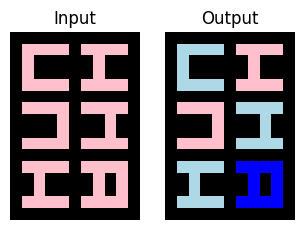

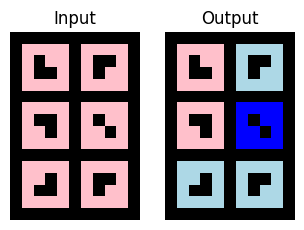

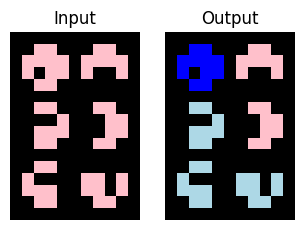

Test Input: 1


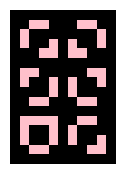

Human Error 5 of 6


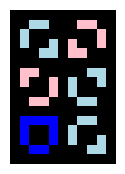

Training examples: 3


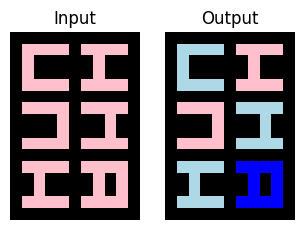

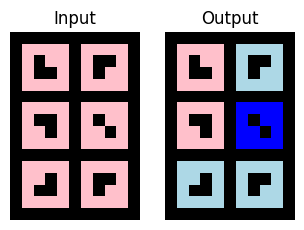

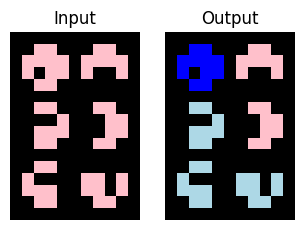

Test Input: 1


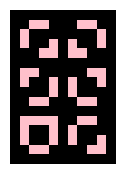

Human Error 6 of 6


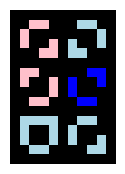


Training examples: 4


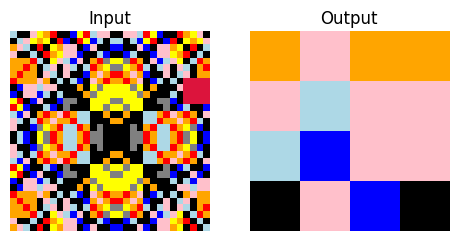

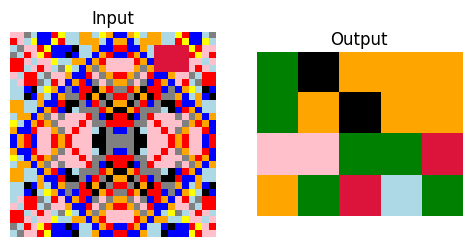

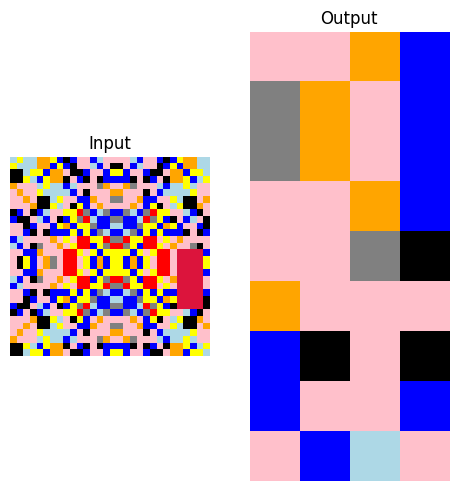

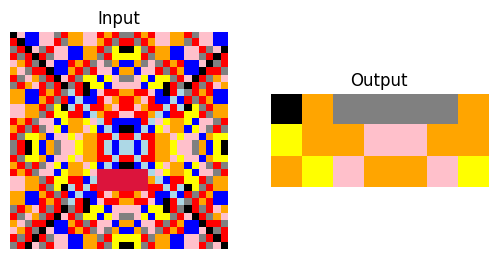

Test Input: 1


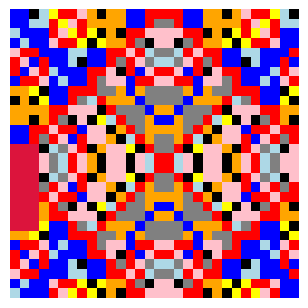

In [ ]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

cmap = mcolors.ListedColormap(["#000000","#808080", "#ADD8E6", "#0000FF", "#008000", "#FFFF00", "#FFA500", "#FF0000", "#DC143C", "#FFC0CB"])
def process_json_file(file_path):
    with open(file_path) as fp:
        data = json.load(fp)
        print("Training examples:", len(data['train']))

        for i in range(len(data['train'])):
            input_grid = np.array(data['train'][i]['input'])
            output_grid = np.array(data['train'][i]['output'])
            fig, axes = plt.subplots(1, 2, figsize=(input_grid.shape[1] / 6 + output_grid.shape[1] / 6, max(input_grid.shape[0]/2, output_grid.shape[0]) / 2))

            axes[0].imshow(input_grid, cmap=cmap, interpolation='nearest')
            axes[0].set_title("Input")
            axes[0].axis('off')

            axes[1].imshow(output_grid, cmap=cmap, interpolation='nearest')
            axes[1].set_title("Output")
            axes[1].axis('off')
            plt.show()

        print("Test Input:", len(data['test']))
        test_input_grid = np.array(data['test'][0]['input'])
        plt.figure(figsize=(test_input_grid.shape[1] / 8, test_input_grid.shape[0] / 8))  # Proportional size based on grid dimensions
        plt.imshow(test_input_grid, cmap = cmap, interpolation='nearest')
        plt.axis('off')
        plt.show()

def process_human_errors(s):
    return np.array([[int(char) for char in row] for row in s.strip('|').split('|')])

for index, row in summary_2.iterrows():
      print(index, row['task_name'][:-5], len(row['test_output_grid_list']))

      for i in range(len(row['test_output_grid_list'])):
          error_grid = process_human_errors(row['test_output_grid_list'][i])
          process_json_file(os.path.join(evaluation_challenges_path, row['task_name']))
          print("Human Error", i + 1, 'of', len(row['test_output_grid_list']))
          plt.figure(figsize=(error_grid.shape[1] / 8, error_grid.shape[0] / 8))
          plt.imshow(error_grid, cmap = cmap, interpolation='nearest')
          plt.axis('off')
          plt.show()
      print()

      # process_json_file(os.path.join(evaluation_challenges_path, row['task_name']))
process_json_file(os.path.join(evaluation_challenges_path, summary_2.iloc[0]['task_name']))